# TUTORIAL Week 3  : Hill-Climbing and Simulated Annealing

In this tutorial you will practice writing local-search algorithms to solve a travelling-salesman problem in Python.

If you are new to Python don't worry. The tutorial will first walk you through an example of creating  hill-climber. Even if you know Python, you still should go over these steps.  The  first part of the tutorial covers

1. How to create random instances of TSP problems, and visualise them
2. Trying to solve small instances using an exact method
3. Writing a hill-climber to solver TSP (step by step instructions)
4. Some plotting functions fo visualise what's happening

Once you have completed this part, there are some tasks you need to complete (all described in the notebook below):

1. Conduct some experiments to understand the variance in results produced
2. Write your own **neighbourhood operator** and repeat the hill-climbing experiments
3. Write a **simulated-annealing algorithm**
4. Conduct some experiments to compare simulated annealing to a hill-climber on the same problem

If you have never used Jupyter Notebook before:

1. You can "run" the cells containing code by highlighting the cell and clicking Run in the mneu  in order to execute the code
2. You shoud work through the cells in order as some of the cells contain definitions that define functions that are used lates
3. You can add new cells with new code in them to test more examples or just alter the code in the cell
 

In [3]:
# first import some libraries we will need

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import operator, time, itertools, math
from random import randint

## Generating some test problems: representing cities and calculating tour lengths
We need to represent multiple cities that need to be visited. Each city is located at a pair of coordinates (x,y). There are many ways we could represent this in Python. Here, we use a "trick" and use the complex number representation from python which represent a single complex number as two parts: *x* + *y*j. 

The reason this is helpful is that we can intrepret the two parts x,y as the two coordinates we need, and access each coordinate easily for plotting etc.  So for example, cities  at (300,400) and (10,20) are created as:

 - City (300,400)  = 300+400j
 - City (10,20) = 10 +20j


We define a constructor to make new cities as below

In [2]:
City = complex # Constructor for new cities, e.g. City(300, 400)


The nice thing about using this representation is that the Euclidean distance  between any two cities is just given by the *absolute difference* between the two numbers.

To make things simpler later on, we will define a function to return the distance between any two cities:


In [3]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return abs(A - B)

In [4]:
# an example creating 2 cities and calculating their the distance between them

n1 = City(0,0)
n2 = City(3,4)
d = distance(n1,n2)
print(d)

5.0


We will also define a function to create a set of cities at random - you can specify how many cities you want to create, and the coordinates of the grid on which they should be placed.

In [5]:
def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    return set(City(random.randrange(10, 890), 
                    random.randrange(10, 590)) 
                for c in range(n))

So, if for example we want to generate  10 cities we can do it like this. Look at the output - it is a list of complex numbers - there are 10 cities in the list, and each city has two coordinates

In [8]:
cities10 = generate_cities(10)
cities10

{(117+139j),
 (129+219j),
 (231+267j),
 (233+42j),
 (329+528j),
 (614+135j),
 (637+513j),
 (757+233j),
 (796+183j),
 (860+421j)}

## Viewing the test instances
We can have a look at the 2d map of the cities we have just created. To make it easy to use Python's plot function, we write an extra function to extract the x,y coordinates as two separate lists from the set of complex numbers we have created above.

In [9]:
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

Now we can plot the points using this function:

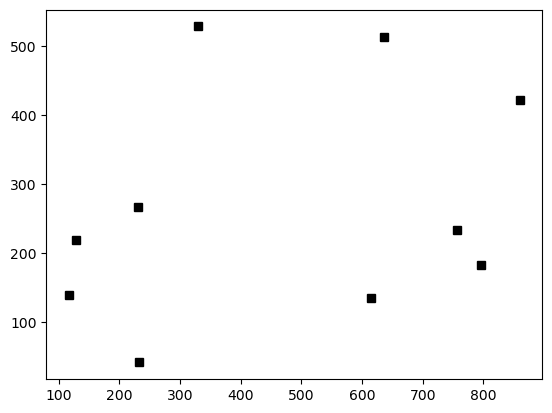

In [10]:
X, Y = XY(cities10)
    
plt.plot(X, Y, 's', color='black')

## Creating a tour
Now we have the cities, we can make a tour around them: for now, let's just make a tour that  uses the order the cities were generated in (as in the list above). This function will make an ordered tour from the list of cities passed to it (in the order given in the list)

In [11]:
def make_tour(cities):
    tour = list()
    for city in cities:
        tour.append(city)
    return tour

In [12]:
myfirst_tour = make_tour(cities10)

We can also have a look at the tour: to help visualise it, we will define another helper function just for plotting (if you are not familiar with Python, don't worry too much about plotting for now... it's more important to understand the algorithms)

In [13]:
# helper function for plotting - this just draws a line between two points
    
def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    
    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)
    

Now we can define a function to plot the tour - we just pass it any tour of cities

In [14]:
def plot_tour(tour, alpha=1, color=None):
    # Plot the tour (starting city is shown as a square)
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    # plt.show()

For example, we can pass it the tour we just created: 

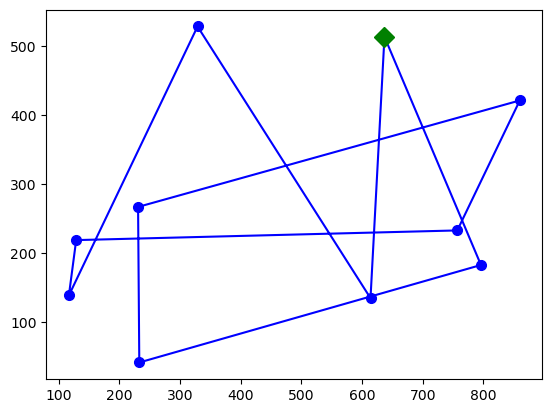

In [15]:
plot_tour(myfirst_tour)

Another useful function is the following: it just creates a random permutation of an existing tour.

If you can run the two cells below several times - and see examples of the different tours generated when it is passed the original tour which visited the cities in exactly the order they were generated.

In [ ]:
random_t = np.random.permutation(myfirst_tour)
plot_tour(random_t)


## Generating all possible tours (small problems only!!)


How many possible tours are there? The following function *all_tours* will generate **all possible** permutations of a set of cities.    But recall in the lecture we discussed that this type of problem suffers from a combinatorial explosion so most problems are too difficult to solve like this.

You might also remember that actually, not all of these tours are unique:  the tours 1-2-3-4-5,  2-3-4-5-1, 3-4-5-1-2, 4,5,1,2,3 and 5,1,2,3,4 actually represent exactly the same sequence.  If we want to use an **exact** method to solve the problem (one that examines every possible solution) we can save ourselves a lot of time by removing all the redundant tours.

Let's define some helper functions - again, don't worry too much about the Python here:
 - *non-redundant_tours()* removes the duplicates: it uses the python method itertools to generate all permtuations that start with the same city
 - *exact_non_redundant_TSP()* generates all the non-redundant tours and then finds the shortest one
 - *total_distance()* returns the total distance travelled by completing a tour in the order specified. This takes advantage of a Python-specific trick: when i is 0, then distance(tour[0], tour[-1]) gives us the wrap-around distance between the first and last cities, because tour[-1] is the last element of tour).
 - *shortest()* just finds the shortest from a list, using the distance method above

 
    

In [20]:
def all_non_redundant_tours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + list(tour)
            for tour in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    for x in collection: return x

def exact_non_redundant_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(all_non_redundant_tours(cities))

def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))
def shortest(tours): 
    "Return the tour with the minimum total distance."
    return min(tours, key=total_distance)


alltours = itertools.permutations # The permutation function is already defined in the itertools module




## How long does it take?

Now we have the tools, let's generate some cities, generate all non redundant tours and find the shortest. We will plot the result and also time to to see how long it takes:




1.  Run the code below (in cell 28) for 5 cities
2.  Repeat for 8 cities and 10 cities

<font color=red> Warning... don't try with more cities than this!!  (in the table I have filled in the time obtained for 12 cities on my computer (MacBook Pro) for 12 cities and extrapolated this to 24) </font>


| n cities | average time |
| ---- | ---- |
| 5  | |
| 8  | |
| 10 |  |
| 12 | 2 mins and 1 second |
| 14 | ~20 hours |
| 24 | ~16 billion years |



**<font color=red>Clearly this is not practical!! Instead you now going to develop some local search methods as explained in the lecture</font>**!


In [ ]:
cities = generate_cities(5)
best = exact_non_redundant_TSP(cities)
plot_tour(best)

# the timing loop repeats the function 10 times so we can get an average
%timeit -n 1 -r 10 exact_non_redundant_TSP(cities)

##  Writing a hill-climber to solve TSP

We now have nearly all the tools need to write a hill-climber:
- a function to generate x cities
- a function to generate a tour
- a function to generate a random permutation of a tour

We just need a **neighbourhood operator** to make a change to an existing permutation.

The first operator we will try is the **swap function** as discussed in the lecutre and given below. It works as follows:

- pick a random positiion in the tour (position1)
- pick another random position (position2)
- swap the values (cities) at those positions

**Question: does it matter if *position1* and *position2* are the same?? Why not?**

The function is passed an existing tour and then returns a modified version.  Notice that it first copies the existing tour and modifies the copy - this is important, as we don't want to over-write the existing tour. 



In [16]:
def apply_neighbourhood_swap(individual):
    new_tour = individual.copy()
    position1 = randint(0,len(individual)-1)
    position2 = randint(0,len(individual)-1)
    city1 = individual[position1]
    city2 = individual[position2]
    new_tour[position1] = city2
    new_tour[position2] = city1
    
    return new_tour

Now we can define the hill-climber  function (refer back to the lecture notes if you are unsure)

The function is passed a random start tour, and iterates for a fixed number of trials, returning the best tour found.

A reminder of the algorithm:

+ set a random start tour (by randomising the tour above using np.random.permutation(start_tour) 
+ calculate distance of start tour
+ loop until max iterations:
    - copy tour then apply a **neighbourhood operator** to change it
    - calculate distance of modified tour
    - if modified tour is better than existing tour, replace the existing tour with the new one, and update the best fitness




In [25]:
def hill_climber(tour, max_tries):


    # and note the distance for this 
    best_tour = tour
    best_dist = total_distance(tour)



    # create a list and add the fitness of the starting tour (this is just for the purpose of plotting later)
    fitness_vals = list()
    fitness_vals.append(best_dist)

    # now run the HC loop : 
    for i in range(max_tries-1):
        new_tour = apply_neighbourhood_swap(best_tour)
        new_tour_dist = total_distance(new_tour)
        if (new_tour_dist < best_dist):
            # update the best distance and replace the current tour with the new one
            best_dist = new_tour_dist
            best_tour= new_tour.copy()
        
        #  add the current fitness to the list   (so we can plot it later)
        fitness_vals.append(best_dist)
        
    # return the results
    return best_dist, best_tour, fitness_vals



Now we are ready to create a test instance and then run the hill-climber:

In [26]:
# CODE TO RUN THE HILL CLIMBER

# create a 50 tour problem and join them into a tour
test_instance = generate_cities(50)
tour = make_tour(test_instance)

# start from a random version of this tour
start_tour = np.random.permutation(tour)

max_tries=10000
# pass this randomised tour to the hill-climber
best_dist, best_tour, fits = hill_climber(start_tour,max_tries)


You can plot the best tour found and print the best distance:

shortest distance found is  5132.097194292399


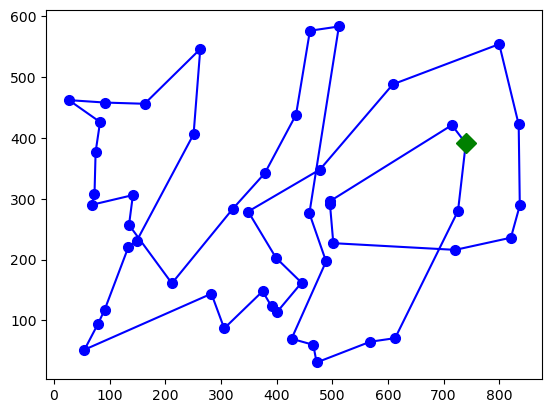

In [27]:
plot_tour(best_tour)
print("shortest distance found is " , best_dist)


.. and also plot the change in fitness overtime

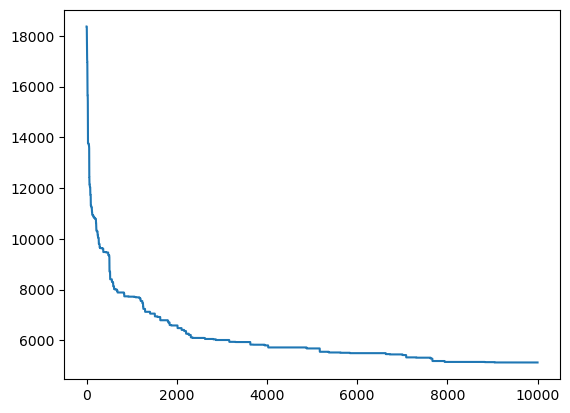

In [28]:


xvals=list(range(max_tries)) 
plt.plot(xvals,fits)

## Task 1:   how much variation is there when the hill-climber is run multiple times?

1.  As the hill-climber is stochastic, it can produce a different result every time it is run. In the cell below, first copy the code above  (cell 55) that calls the hill-climber and then modify it so that instead of running it once, it calls it 10 times. Each time record the best fitness found and add it to a list. At the end, calculate the mean and standard deviation of the 10 runs (use the numpy function np.mean(), np.std() ). What do you notice? What is the best distance? What is the worst distance?

2.  Repeat this exercise with a problem that has 100 cities. What do you notice about the standard deviation in results?

3. Write a new **move operator** of your choosing. It might invert a random segment of the tour, or apply multiple swaps, or.....     If you are feeling confident, then you can implement the **2-opt operator**. This is the best-known operator for TSP -  see https://en.wikipedia.org/wiki/2-opt for a description. Rerun the hill climber 10 times and compare the mean result with your new operator to the swap operator you already tested



In [ ]:
# Task 1 (a) run hill-climber multiple times and calculate statistics over runs:

In [ ]:
# Task 1 (b) repeat using 100 cities

In [ ]:
# Task 1 (c) write a new neighbourhood operator

## Task 2:  Implementing a Simulated Annealing Algorithm

In the lecture we discussed the Simulated Annealing which extends the hill-climber by accepting solutions that are worse than the current solution, based on a calculation that includes a temperature factor and the difference in fitness between the current and potential solutions.

**Now implement an Simulated Annealing algorithm** (make a copy of the hill-climber code and start from here). Refer to the lecture slides for the algorithm

You will need to:
 - add a *temperature* variable, that can be initialised to a value of your choice (*start_temp*)
 - reduce the temperature by a small amount each step (the *cooling_rate*) -for example, multiply by a factor 0.99 etc.
 - calculate the probability of acceptance using the **current temperature** and the **difference** in fitness using the equation explained on the lecture slides, i.e:  *p = exp(-d/T)*, where *d* is the difference (new fitness-current fitness) and *T* is the current temperature
 
To determine whether to accept a new solution that is worse than the current solution:
  - generate a random number between 0 and 1
  - if this random number is less than the probability calculated in the previous step, accept the solution

**Testing and experimenting with your algorithm**

1. Test your algorithm on the same 50 city problem. Suggested values for algorithm parameters are a start temperature of XXX and  cooling rate=0.99. Run the algorithm 10x and compare the mean result to the hillclimber

2. Plot the change in fitness over time: you may want to zoom in on the first 100 or so iterations: notice how often (or not) a poorer solution is accepted 

3. Experiment with altering the starting temperature: what happens if it is very high? very low? if you plot the fitness over time, how does the graph change when you start at different temperatures?
4. Experiment with the cooling rate - what happens if you cool very quickly? Again, plot the graph of fitness over time to get insight into what is happening


In [ ]:
# Task 2(a)
def simulated_annealing()

# start with the hill climber code and modify